In [ ]:
import torch
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
%%bash
pip install numpy scipy scikit-image matplotlib

In [ ]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
ssd_model.to('cuda')
ssd_model.eval()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tarfile
from google.colab import files
tar = tarfile.open("/content/gdrive/MyDrive/Colab Notebooks/cats_dogs_dataset.tar", "r")
tar.extractall('/content')

In [ ]:
import os
import re

def get_images(path):
  l = []
  for root, dirs, files in os.walk(path): 
      for filename in files:
        if re.findall(r'.jpg', filename):
            l.append(path + '/' + filename)
  return l
              

In [ ]:
uris = get_images('/content/cats_dogs_dataset/valid')

In [ ]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

In [ ]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [ ]:
results_per_input = utils.decode_results(detections_batch)

In [ ]:
best_results_per_input = [utils.pick_best(results, 0.20) for results in results_per_input]

In [ ]:
classes_to_labels = utils.get_coco_object_dictionary()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


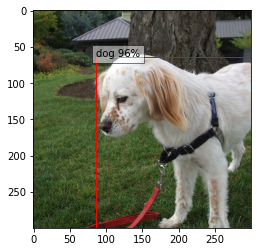

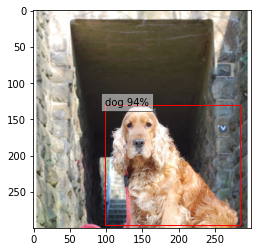

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches


# Для примеры выведем n картинок
n = 2
for image_idx in range(n):
    fig, ax = plt.subplots(1)
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()